In [ ]:
# !pip install pyvi

In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import string
from pyvi import ViTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, callbacks, preprocessing, losses, optimizers, utils
from src.dtprocess import cleandt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# %cd /content/drive/My Drive/School/Năm 3/DataMining/FinalTerm

/content/drive/My Drive/School/Năm 3/DataMining/FinalTerm


In [5]:
# %ls

data/               generate_text.ipynb  text-classification.ipynb
Final_Project.gdoc  model/               text_generator.ipynb


## Import data from source

In [12]:
vnexpress = pd.read_csv('./data/vnexpress/csv/cleaned_vnexpress.csv').drop(columns=['Unnamed: 0'], axis=1)
vnexpress.shape

(2481, 6)

In [13]:
vnexpress.head()

,article_id,topic,sub-topic,title,url,tag
0,0,doi-song,to-am,Bức tường hoa hồng bao quanh nhà người phụ nữ ...,https://vnexpress.net/buc-tuong-hoa-hong-bao-q...,khi mua ngôi nhà mới ở bắc california cả mảnh ...
1,1,doi-song,to-am,Vợ phát hiện từng dự đám cưới của chồng năm 9 ...,https://vnexpress.net/vo-phat-hien-tung-du-dam...,cô gái 24 tuổi ở quần_đảo bangkabelitung indon...
2,2,doi-song,to-am,70 ngày kéo vợ và con trở về từ cõi chết,https://vnexpress.net/70-ngay-keo-vo-va-con-tr...,mọi thứ ập đến với anh quá nhanh khoảng 7h sán...
3,3,doi-song,to-am,Những đứa trẻ được 'bật đèn xanh' yêu sớm,https://vnexpress.net/nhung-dua-tre-duoc-bat-d...,mẹ bảo hồi bằng tuổi cháu cũng yêu một bạn cùn...
4,4,doi-song,to-am,Đời bi kịch của người phụ nữ gánh cả gia đình,https://vnexpress.net/doi-bi-kich-cua-nguoi-ph...,tôi suy_sụp đứng không vững nhưng phải tự trấn...


In [20]:
mask = vnexpress['tag'].isna()
vnexpress[mask]

,article_id,topic,sub-topic,title,url,tag


In [19]:
vnexpress.dropna(axis=0, inplace=True)
vnexpress['topic'].value_counts()

topic
giai-tri    616
the-thao    510
khoa-hoc    450
doi-song    363
giao-duc    358
du-lich     182
Name: count, dtype: int64

In [21]:
news = vnexpress.copy()
label_encoder = LabelEncoder()
news['topic'] = label_encoder.fit_transform(vnexpress['topic'])
news['tag'] = news['tag'].apply(lambda x: cleandt.remove_stopword(x, './data/vietnamese-stopwords-dash.txt'))

news.head()

,article_id,topic,sub-topic,title,url,tag
0,0,0,to-am,Bức tường hoa hồng bao quanh nhà người phụ nữ ...,https://vnexpress.net/buc-tuong-hoa-hong-bao-q...,mua bắc california mảnh vườn 670 m2 cây_xanh d...
1,1,0,to-am,Vợ phát hiện từng dự đám cưới của chồng năm 9 ...,https://vnexpress.net/vo-phat-hien-tung-du-dam...,gái 24 quần_đảo bangkabelitung indonesia tình ...
2,2,0,to-am,70 ngày kéo vợ và con trở về từ cõi chết,https://vnexpress.net/70-ngay-keo-vo-va-con-tr...,ập 7h 143 chiến bật dậy tiếng kêu vợ cử_động c...
3,3,0,to-am,Những đứa trẻ được 'bật đèn xanh' yêu sớm,https://vnexpress.net/nhung-dua-tre-duoc-bat-d...,mẹ bảo hồi cháu yêu lớp yêu tâm_trạng cháu bé ...
4,4,0,to-am,Đời bi kịch của người phụ nữ gánh cả gia đình,https://vnexpress.net/doi-bi-kich-cua-nguoi-ph...,suy_sụp đứng vững trấn_an dựa sen 60 xã kim li...


## Initialize the corpus

In [14]:
def word_separation(sentences):
    return [sen.split() for sen in sentences]

In [7]:
def clean_document(doc):
    doc = ViTokenizer.tokenize(doc)
    doc = doc.lower() # lower
    tokens = doc.split() # split into words
    table = str.maketrans('', '', string.punctuation.replace("_", "")) # remove all punctuations
    tokens = [w.translate(table) for w in tokens]
    tokens = [word for word in tokens if word]
    return tokens

In [8]:
def create_sequences(data):
    papers = data['tag'].tolist()
    sequences = []
    for seq in tqdm(papers):
        tokens = clean_document(seq)
        line = ' '.join(tokens)
        sequences.append(line)
    return sequences

In [9]:
def create_input(tokenizer, sequences:list, max_length:int):
    sequence_digit = tokenizer.texts_to_sequences(sequences)
    print(sequence_digit[0])
    print(type(sequence_digit))
    input_sequences = np.array(preprocessing.sequence.pad_sequences(sequence_digit, maxlen=max_length, padding='pre'))
    return input_sequences

In [19]:
sequences = create_sequences(news)
print('Length of sequences:', len(sequences))
sequences[2]

100%|██████████| 1979/1979 [00:19<00:00, 100.27it/s]


In [21]:
input_sequences = word_separation(sequences)
print(input_sequences[0:2])

[['lệ', 'nguyễn', 'tổng_hợpđịa', 'phương', 'nắng', 'địa_phương', 'trung_bình', '109', 'nắng', 'nắng'], ['cỗ', 'máy_trí_tuệ', 'nhân_tạo', 'thể_hiện', 'hiệu_suất', 'ưu_việt', 'trận', 'chiến', 'đối_thủ', 'thường_xuyên', 'hạ', 'phong', 'nghiên_cứu', 'công_bố', 'kết_quả', 'chiến_đấu', 'thử_nghiệm', 'tạp_chí', 'acta', 'aeronautica', 'et', 'astronautica', 'sinica', 'trung', 'quốc', 'hôm', '272', 'quân_đội', 'mỹ', 'phi_công', 'nhiệm_vụ', 'thử_nghiệm', 'bao_gồm', 'diễn_tập', 'chiến_đấu', 'máy_bay', 'tiêm_kích', 'f16', 'trận', 'không_chiến', 'bao_gồm', 'hai', 'máy_bay', 'cánh', 'cố_định', 'phi_công', 'cabin', 'điều_khiển', 'máy_bay', 'phiển', 'phi_công', 'mặt_đất', 'trận', 'chiến', 'phi_công', 'di_chuyển', 'chiếm', 'thượng_phong', 'phi_công', 'dự_đoán', 'ý_đồ', 'đối_thủ', 'đi', 'đối_phó', 'bám', 'sát_nút', 'máy_bay', 'con_người', 'điều_khiển', 'lao', 'chúi', 'dụ', 'máy_bay', 'cầm', 'lái', 'đâm', 'đất', 'phi_công', 'di_chuyển', 'phục_kích', 'chờ', 'đối_thủ', 'bay', 'phi_công', 'thực', 'thử', 'chi

In [22]:
# filter several punctuations in 50803 sentences
tokenizer = preprocessing.text.Tokenizer(filters='!“"”#$%&()*+,-./:;<=>?@[\]^`{|}~ ', oov_token='<oov>')
# create vocabulary (corpus) for each word in 50803 sentences
tokenizer.fit_on_texts(input_sequences)

print(len(tokenizer.word_index))

34481


In [23]:
max_length = max([len(i) for i in sequences])
max_length

12731

In [24]:
topic_size = len(news['topic'].unique()) + 1
topic_size

7

## Split into train and test

In [ ]:
X = news[['article_id', 'tag']]
y = news[['topic']]
news_train, news_test, label_train, label_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [ ]:
print("The length of news_train: ", len(news_train))
print("The length of news_test: ", len(news_test))

In [ ]:
print(label_train.value_counts())
print(label_test.value_counts())

In [25]:
sequences_train = create_sequences(news_train)
X_train = create_input(tokenizer, sequences_train, max_length)

print(len(X_train))
print(X_train[0:2])

[1345, 20, 14969, 92, 635, 416, 731, 5239, 635, 635]
<class 'list'>
12731
[[   0    0    0 ... 5239  635  635]
 [   0    0    0 ... 1453  752 2252]]


In [27]:
## Sửa định dạng y
y_train = np.array([label_train['topic']])
y_train = y_train.reshape(-1, 1)
y_train = utils.to_categorical(y_train, num_classes=topic_size)

print(y_train[0:5])

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


## Design the LSTM model

In [28]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

34482

In [29]:
drop_out = 0.2
output_unit = topic_size
embedding_size = 128

In [30]:
model = models.Sequential([
  layers.Embedding(vocab_size, embedding_size),
  layers.BatchNormalization(),
  layers.LSTM(64, return_sequences=True),
  layers.LSTM(64, return_sequences=True),
  layers.LSTM(64),
  layers.Dropout(drop_out),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(9, activation='relu'),
  layers.Dense(units=output_unit, activation='softmax')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         4413696   
                                                                 
 batch_normalization (Batch  (None, None, 128)         512       
 Normalization)                                                  
                                                                 
 lstm (LSTM)                 (None, None, 64)          49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 9)                 585       
                                                       

In [31]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train, epochs=20, batch_size=64)

Epoch 1/25
31/31 [==============================] - 35s 1s/step - loss: 1.5123 - accuracy: 0.4498
Epoch 2/25
31/31 [==============================] - 36s 1s/step - loss: 1.3010 - accuracy: 0.4617
Epoch 3/25
31/31 [==============================] - 35s 1s/step - loss: 1.0923 - accuracy: 0.4876
Epoch 4/25
31/31 [==============================] - 35s 1s/step - loss: 0.9594 - accuracy: 0.4835
Epoch 5/25
31/31 [==============================] - 35s 1s/step - loss: 0.8481 - accuracy: 0.5093
Epoch 6/25
31/31 [==============================] - 35s 1s/step - loss: 0.7342 - accuracy: 0.6101
Epoch 7/25
31/31 [==============================] - 36s 1s/step - loss: 0.5942 - accuracy: 0.7689
Epoch 8/25
31/31 [==============================] - 36s 1s/step - loss: 0.4808 - accuracy: 0.7689
Epoch 9/25
31/31 [==============================] - 35s 1s/step - loss: 0.4037 - accuracy: 0.7725
Epoch 10/25
31/31 [==============================] - 36s 1s/step - loss: 0.3743 - accuracy: 0.7937
Epoch 11/25
31/31 [

KeyboardInterrupt: 

## Dump model into files

In [ ]:
# %cd /content/drive/My Drive/School/Năm 3/DataMining/FinalTerm/model

In [ ]:
import pickle
model.save('./model/text_classify_model.h5')

with open('./model/text_classify_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

## Predict samples and Evaluate on test dataset

In [4]:
import pickle
model = models.load_model('./model/text_classify_model.h5')

with open('./model/text_classify_tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [2]:
def normalize_text(text, tokenizer, max_length):
    tokeninzed_sequences = clean_document(text)
    sequences_digit = tokenizer.texts_to_sequences([tokeninzed_sequences])
    sequences_digit_padding = np.array(preprocessing.sequence.pad_sequences(sequences_digit, maxlen=max_length, padding='pre'))
    return sequences_digit_padding

* Predict a sample

In [3]:
sample_text = '''
chiến_thắng giúp leverkusen nới rộng khoảng_cách với đội nhì bảng bayern lên tám điểm tạo áp_lực cho đối_thủ trước chuyến làm_khách trên sân bochum vào tối 182 leverkusen vẫn chưa thua trận nào mùa này họ đã bất_bại 32 trận liên_tiếp trên mọi đấu_trường
'''

In [10]:
temp = normalize_text(text=sample_text, tokenizer=tokenizer, max_length=12731)
print(temp)

prediction = model.predict(temp)
print(prediction)

[[   0    0    0 ...    1    1 2257]]
1/1 [==============================] - 4s 4s/step
[[1.8311549e-02 4.6005430e-06 1.7284302e-11 4.1136104e-07 6.3665416e-03
  9.7531676e-01 3.9073272e-10]]


In [22]:
result = label_encoder.inverse_transform([np.argmax(prediction[0])])
result

array(['the-thao'], dtype=object)

* Evaluate performance

In [82]:
sequences_test = create_sequences(news_test)
X_test = create_input(tokenizer, sequences_test, max_length)

print(len(X_test))
print(X_test[0:2])

19362
[[    0     0     0 ... 17806     3    22]
 [    0     0     0 ...  3839   881    99]]


In [83]:
prediction = model.predict(X_test)
print(prediction)

16/16 [==============================] - 6s 378ms/step
[[9.8521960e-01 1.4395811e-02 3.8428715e-04 ... 1.1981915e-10
  4.6032075e-17 1.5749091e-10]
 [7.7254422e-02 8.7108714e-07 9.2274475e-01 ... 2.5355044e-12
  4.8677755e-16 1.0200513e-12]
 [8.9728971e-26 1.9460379e-21 2.6630151e-21 ... 1.8669970e-03
  9.9813288e-01 2.7949772e-24]
 ...
 [2.4271754e-03 8.2468218e-01 1.0646195e-08 ... 4.5956978e-05
  4.5604194e-13 1.0247684e-08]
 [7.7240795e-02 9.2231369e-01 1.8696507e-07 ... 3.2922141e-08
  8.0584459e-16 5.2300453e-09]
 [3.7195696e-03 9.2340002e-09 9.9628037e-01 ... 7.9860424e-13
  8.2436846e-16 5.9299225e-14]]


In [84]:
predictions = [np.argmax(pred) for pred in prediction]
print(mean_squared_error(label_test, predictions))
print(r2_score(label_test, predictions))

0.7045454545454546
0.7320518544374184


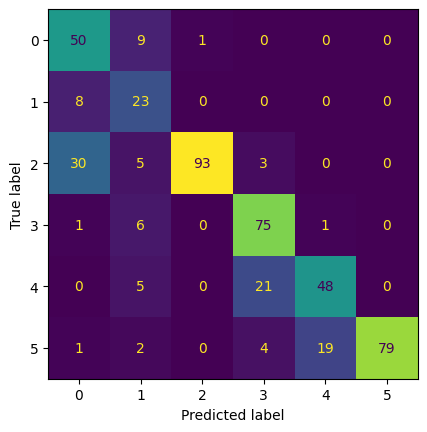

In [85]:
cm = confusion_matrix(label_test, predictions)
cfm = ConfusionMatrixDisplay(confusion_matrix=cm)
cfm.plot(colorbar=False)

In [86]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67        60
           1       0.46      0.74      0.57        31
           2       0.99      0.71      0.83       131
           3       0.73      0.90      0.81        83
           4       0.71      0.65      0.68        74
           5       1.00      0.75      0.86       105

    accuracy                           0.76       484
   macro avg       0.74      0.76      0.73       484
weighted avg       0.82      0.76      0.77       484

